In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_sel_csv, index_col=0, parse_dates=True)
df_feat_sel

,r_5,r_15,vol_15,bb_width_20,rsi_14,stoch_k_14,stoch_d_3,hour,macd_12_26,vwap_dev,atr_14,ma_20,bid,ask,signal
2004-01-02 13:09:00,-0.040971,-0.025534,-0.966783,-0.929333,-1.995735,-1.481580,-1.561625,0.493,0.000000,-0.032030,0.000000,0.000000,0.763664,0.764807,0.077619
2004-01-02 13:10:00,-0.054390,-0.033477,-0.965007,-0.921566,-1.995735,-1.481580,-1.561625,0.493,-1.000000,-0.036171,1.000000,-1.000000,0.763647,0.764790,0.082208
2004-01-02 13:11:00,-0.067809,-0.041420,-0.963779,-0.913246,-1.995735,-1.481580,-1.561625,0.493,-1.052039,-0.040262,1.000000,-1.111111,0.763631,0.764773,0.087074
2004-01-02 13:12:00,-0.067810,-0.049363,-0.963001,-0.904541,-1.995735,-1.481580,-1.561625,0.493,-1.049817,-0.044296,1.000000,-1.133333,0.763614,0.764757,0.092235
2004-01-02 13:13:00,-0.067812,-0.057307,-0.962622,-0.895592,-1.995735,-1.481580,-1.561625,0.493,-1.051188,-0.048268,1.000000,-1.181818,0.763597,0.764740,0.097706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,1.742521,1.317936,0.507307,0.122381,0.750521,0.619888,0.342752,-0.939,1.966827,0.407906,2.101234,-0.132433,196.667400,196.962600,0.417935
2025-06-18 20:57:00,0.887590,1.115397,0.566581,0.187641,0.451158,0.223810,0.415204,-0.939,2.007157,0.263954,2.263666,-0.095682,196.527500,196.822500,0.368513
2025-06-18 20:58:00,0.341995,0.828890,0.542508,0.241322,0.386888,0.209943,0.370103,-0.939,2.010664,0.254269,2.242849,-0.061664,196.522500,196.817500,0.365417
2025-06-18 20:59:00,-0.842944,-0.094079,0.903328,0.245429,0.030308,-0.982637,-0.192907,-0.939,1.616873,-0.173638,2.504253,-0.063324,196.092800,196.387200,0.280949


In [4]:
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2412342, 60, 12]) (samples, look_back, features)
  y_sig     = torch.Size([2412342]) (samples,)
  y_ret     = torch.Size([2412342]) (samples,)
  raw_close = torch.Size([2412342])
  raw_bid   = torch.Size([2412342])
  raw_ask   = torch.Size([2412342])
  end_times = (2412342,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1694522, 60, 12])
  y_sig_tr, y_ret_tr = torch.Size([1694522]) torch.Size([1694522])
  X_val = torch.Size([353129, 60, 12])
  y_sig_val, y_ret_val = torch.Size([353129]) torch.Size([353129])
  X_te  = torch.Size([364691, 60, 12])
  y_sig_te, y_ret_te = torch.Size([364691]) torch.Size([364691])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3808, val=783, test=809
Batches → train=119,   val=783,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(12, 12, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(12, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 5e-05
    lr: 5e-05
    maximize: False
    weight_decay: 0.001
)

In [9]:
# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

Training sees 3808 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.414885


In [10]:
# # grab one batch from the train loader
# batch = next(iter(train_loader))

# # unpack it
# x_seq, y_sig_seq, y_ret_seq, *rest = batch

# print("x_seq shape   ", x_seq.shape)
# print("y_sig_seq     ", y_sig_seq.shape, " NaNs? ", torch.isnan(y_sig_seq).any().item())
# print("y_ret_seq     ", y_ret_seq.shape, " NaNs? ", torch.isnan(y_ret_seq).any().item())


# # move to device
# x_seq = x_seq.to(params.device)
# y_sig_seq = y_sig_seq.to(params.device)
# y_ret_seq = y_ret_seq.to(params.device)

# # forward‐only (no backward yet)
# with torch.no_grad():
#     pr, pc, _ = model(x_seq)

# print("pr shape       ", pr.shape)
# print("pc shape       ", pc.shape)
# print("any NaN in pr? ", torch.isnan(pr).any().item())
# print("any NaN in pc? ", torch.isnan(pc).any().item())


In [11]:
# import torch.nn as nn

# # 1) recreate your losses (use the same β, weights, thresholds)
# huber   = nn.SmoothL1Loss(beta=params.hparams["HUBER_BETA"])
# bce     = nn.BCEWithLogitsLoss()
# ce      = nn.CrossEntropyLoss()
# alpha   = params.hparams["CLS_LOSS_WEIGHT"]
# ret_thr = 0.01                # or your return_thresh

# # 2) flatten batch×window dims to match pr/pc
# #    pr,pc shapes: (batch*W, seq_len, heads)
# #    we take the last time‐step along seq_len
# pr_last = pr[:, -1, 0]        # (batch*W,)
# pc_last = pc[:, -1, :]        # (batch*W, #classes or 1)

# # 3) regression loss
# sig_true  = y_sig_seq.reshape(-1).to(pr.device)  # (batch*W,)
# sig_hat   = torch.sigmoid(pr_last)
# reg_loss  = huber(sig_hat, sig_true)

# # 4) binary‐cls loss
# cls_logits = pc[:, -1, 0]     # same dim as pr_last
# cls_true   = (sig_true > params.best_optuna_params["buy_threshold"]).float()
# cls_loss   = bce(cls_logits, cls_true)

# # 5) ternary‐return loss
# ret_true   = y_ret_seq.reshape(-1).to(pr.device)
# ter_true   = torch.ones_like(ret_true, dtype=torch.long)
# ter_true[ ret_true >  ret_thr] = 2
# ter_true[ ret_true < -ret_thr] = 0
# ter_loss   = ce(pc_last, ter_true)

# # 6) total
# loss = reg_loss + alpha*cls_loss + ter_loss

# print("reg_loss:", reg_loss.item())
# print("cls_loss:", cls_loss.item())
# print("ter_loss:", ter_loss.item())
# print("total_loss:", loss.item())
# assert not torch.isnan(loss), "▶️ Loss is NaN here!"


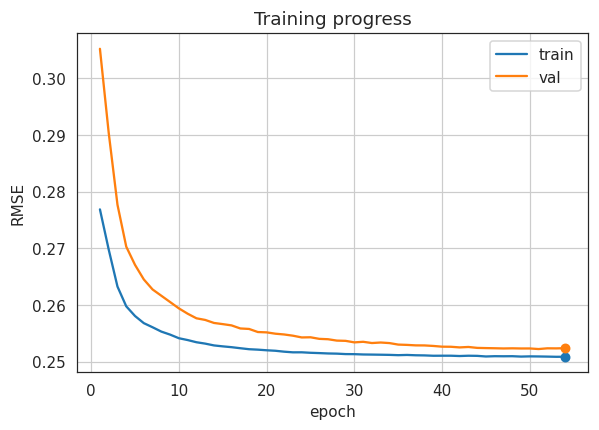

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2769 MAE=0.2053 R2=0.0649 | "B": Acc=0.6875 Prec=0.4509 Rec=0.2010 F1=0.2781 AUROC=0.6390
VALID→ "R": RMSE=0.3052 MAE=0.2093 R2=-0.2272 | "B": Acc=0.7128 Prec=0.8043 Rec=0.0270 F1=0.0522 AUROC=0.6839


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2698 MAE=0.1971 R2=0.1121 | "B": Acc=0.7109 Prec=0.5556 Rec=0.1722 F1=0.2630 AUROC=0.6474
VALID→ "R": RMSE=0.2904 MAE=0.1997 R2=-0.1109 | "B": Acc=0.7241 Prec=0.7518 Rec=0.0878 F1=0.1572 AUROC=0.7075


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2632 MAE=0.1922 R2=0.1546 | "B": Acc=0.7215 Prec=0.5852 Rec=0.2399 F1=0.3403 AUROC=0.6846
VALID→ "R": RMSE=0.2777 MAE=0.1920 R2=-0.0159 | "B": Acc=0.7328 Prec=0.7267 Rec=0.1422 F1=0.2379 AUROC=0.7247


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2598 MAE=0.1894 R2=0.1769 | "B": Acc=0.7298 Prec=0.6054 Rec=0.2800 F1=0.3829 AUROC=0.7083
VALID→ "R": RMSE=0.2703 MAE=0.1875 R2=0.0376 | "B": Acc=0.7415 Prec=0.7168 Rec=0.1958 F1=0.3076 AUROC=0.7375


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2580 MAE=0.1882 R2=0.1877 | "B": Acc=0.7351 Prec=0.6162 Rec=0.3057 F1=0.4087 AUROC=0.7222
VALID→ "R": RMSE=0.2671 MAE=0.1854 R2=0.0603 | "B": Acc=0.7468 Prec=0.7037 Rec=0.2353 F1=0.3527 AUROC=0.7457


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2568 MAE=0.1871 R2=0.1956 | "B": Acc=0.7383 Prec=0.6215 Rec=0.3221 F1=0.4243 AUROC=0.7305
VALID→ "R": RMSE=0.2645 MAE=0.1837 R2=0.0783 | "B": Acc=0.7496 Prec=0.6951 Rec=0.2599 F1=0.3784 AUROC=0.7507


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2561 MAE=0.1865 R2=0.2001 | "B": Acc=0.7397 Prec=0.6227 Rec=0.3313 F1=0.4325 AUROC=0.7354
VALID→ "R": RMSE=0.2627 MAE=0.1825 R2=0.0906 | "B": Acc=0.7512 Prec=0.6920 Rec=0.2730 F1=0.3915 AUROC=0.7543


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2553 MAE=0.1858 R2=0.2049 | "B": Acc=0.7414 Prec=0.6261 Rec=0.3381 F1=0.4391 AUROC=0.7396
VALID→ "R": RMSE=0.2616 MAE=0.1818 R2=0.0983 | "B": Acc=0.7525 Prec=0.6870 Rec=0.2860 F1=0.4039 AUROC=0.7568


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2548 MAE=0.1854 R2=0.2082 | "B": Acc=0.7420 Prec=0.6256 Rec=0.3440 F1=0.4439 AUROC=0.7421
VALID→ "R": RMSE=0.2605 MAE=0.1810 R2=0.1059 | "B": Acc=0.7532 Prec=0.6855 Rec=0.2925 F1=0.4101 AUROC=0.7588


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2541 MAE=0.1849 R2=0.2122 | "B": Acc=0.7431 Prec=0.6282 Rec=0.3474 F1=0.4474 AUROC=0.7448
VALID→ "R": RMSE=0.2594 MAE=0.1802 R2=0.1136 | "B": Acc=0.7537 Prec=0.6846 Rec=0.2966 F1=0.4139 AUROC=0.7604


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2538 MAE=0.1845 R2=0.2142 | "B": Acc=0.7434 Prec=0.6289 Rec=0.3482 F1=0.4482 AUROC=0.7464
VALID→ "R": RMSE=0.2585 MAE=0.1796 R2=0.1200 | "B": Acc=0.7543 Prec=0.6836 Rec=0.3012 F1=0.4181 AUROC=0.7617


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2534 MAE=0.1841 R2=0.2166 | "B": Acc=0.7441 Prec=0.6303 Rec=0.3513 F1=0.4511 AUROC=0.7483
VALID→ "R": RMSE=0.2576 MAE=0.1790 R2=0.1255 | "B": Acc=0.7548 Prec=0.6826 Rec=0.3058 F1=0.4223 AUROC=0.7627


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2532 MAE=0.1838 R2=0.2181 | "B": Acc=0.7447 Prec=0.6316 Rec=0.3530 F1=0.4529 AUROC=0.7498
VALID→ "R": RMSE=0.2574 MAE=0.1788 R2=0.1275 | "B": Acc=0.7553 Prec=0.6819 Rec=0.3097 F1=0.4260 AUROC=0.7637


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2529 MAE=0.1835 R2=0.2201 | "B": Acc=0.7451 Prec=0.6326 Rec=0.3547 F1=0.4545 AUROC=0.7510
VALID→ "R": RMSE=0.2568 MAE=0.1784 R2=0.1311 | "B": Acc=0.7556 Prec=0.6827 Rec=0.3106 F1=0.4269 AUROC=0.7645


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2527 MAE=0.1833 R2=0.2211 | "B": Acc=0.7455 Prec=0.6338 Rec=0.3551 F1=0.4552 AUROC=0.7523
VALID→ "R": RMSE=0.2566 MAE=0.1782 R2=0.1325 | "B": Acc=0.7558 Prec=0.6834 Rec=0.3116 F1=0.4281 AUROC=0.7652


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2525 MAE=0.1831 R2=0.2220 | "B": Acc=0.7457 Prec=0.6350 Rec=0.3545 F1=0.4550 AUROC=0.7530
VALID→ "R": RMSE=0.2564 MAE=0.1780 R2=0.1340 | "B": Acc=0.7561 Prec=0.6849 Rec=0.3112 F1=0.4279 AUROC=0.7658


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2524 MAE=0.1828 R2=0.2231 | "B": Acc=0.7463 Prec=0.6361 Rec=0.3564 F1=0.4569 AUROC=0.7543
VALID→ "R": RMSE=0.2558 MAE=0.1776 R2=0.1376 | "B": Acc=0.7564 Prec=0.6843 Rec=0.3140 F1=0.4305 AUROC=0.7664


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2522 MAE=0.1826 R2=0.2242 | "B": Acc=0.7468 Prec=0.6382 Rec=0.3564 F1=0.4574 AUROC=0.7553
VALID→ "R": RMSE=0.2558 MAE=0.1775 R2=0.1382 | "B": Acc=0.7567 Prec=0.6840 Rec=0.3164 F1=0.4327 AUROC=0.7669


Epoch 19:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2521 MAE=0.1825 R2=0.2246 | "B": Acc=0.7466 Prec=0.6377 Rec=0.3556 F1=0.4566 AUROC=0.7557
VALID→ "R": RMSE=0.2552 MAE=0.1772 R2=0.1419 | "B": Acc=0.7570 Prec=0.6838 Rec=0.3182 F1=0.4343 AUROC=0.7673


Epoch 20:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2520 MAE=0.1823 R2=0.2253 | "B": Acc=0.7471 Prec=0.6394 Rec=0.3561 F1=0.4575 AUROC=0.7565
VALID→ "R": RMSE=0.2552 MAE=0.1771 R2=0.1423 | "B": Acc=0.7570 Prec=0.6850 Rec=0.3170 F1=0.4334 AUROC=0.7677


Epoch 21:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2519 MAE=0.1822 R2=0.2259 | "B": Acc=0.7474 Prec=0.6414 Rec=0.3545 F1=0.4567 AUROC=0.7571
VALID→ "R": RMSE=0.2549 MAE=0.1769 R2=0.1439 | "B": Acc=0.7571 Prec=0.6853 Rec=0.3170 F1=0.4335 AUROC=0.7681


Epoch 22:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2517 MAE=0.1821 R2=0.2269 | "B": Acc=0.7478 Prec=0.6419 Rec=0.3562 F1=0.4581 AUROC=0.7579
VALID→ "R": RMSE=0.2548 MAE=0.1768 R2=0.1448 | "B": Acc=0.7573 Prec=0.6854 Rec=0.3185 F1=0.4349 AUROC=0.7684


Epoch 23:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2516 MAE=0.1819 R2=0.2276 | "B": Acc=0.7481 Prec=0.6435 Rec=0.3558 F1=0.4582 AUROC=0.7584
VALID→ "R": RMSE=0.2546 MAE=0.1766 R2=0.1462 | "B": Acc=0.7575 Prec=0.6858 Rec=0.3189 F1=0.4354 AUROC=0.7687


Epoch 24:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2516 MAE=0.1818 R2=0.2275 | "B": Acc=0.7482 Prec=0.6438 Rec=0.3557 F1=0.4582 AUROC=0.7589
VALID→ "R": RMSE=0.2543 MAE=0.1764 R2=0.1483 | "B": Acc=0.7575 Prec=0.6853 Rec=0.3197 F1=0.4360 AUROC=0.7690


Epoch 25:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2516 MAE=0.1817 R2=0.2280 | "B": Acc=0.7485 Prec=0.6452 Rec=0.3554 F1=0.4584 AUROC=0.7593
VALID→ "R": RMSE=0.2543 MAE=0.1764 R2=0.1481 | "B": Acc=0.7576 Prec=0.6853 Rec=0.3203 F1=0.4366 AUROC=0.7692


Epoch 26:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2515 MAE=0.1816 R2=0.2284 | "B": Acc=0.7488 Prec=0.6463 Rec=0.3556 F1=0.4588 AUROC=0.7598
VALID→ "R": RMSE=0.2540 MAE=0.1762 R2=0.1500 | "B": Acc=0.7577 Prec=0.6847 Rec=0.3218 F1=0.4378 AUROC=0.7694


Epoch 27:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2514 MAE=0.1815 R2=0.2288 | "B": Acc=0.7488 Prec=0.6464 Rec=0.3550 F1=0.4583 AUROC=0.7603
VALID→ "R": RMSE=0.2539 MAE=0.1761 R2=0.1504 | "B": Acc=0.7578 Prec=0.6856 Rec=0.3213 F1=0.4375 AUROC=0.7697


Epoch 28:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2514 MAE=0.1814 R2=0.2290 | "B": Acc=0.7490 Prec=0.6477 Rec=0.3544 F1=0.4581 AUROC=0.7606
VALID→ "R": RMSE=0.2537 MAE=0.1760 R2=0.1520 | "B": Acc=0.7580 Prec=0.6857 Rec=0.3220 F1=0.4382 AUROC=0.7699


Epoch 29:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2513 MAE=0.1814 R2=0.2295 | "B": Acc=0.7492 Prec=0.6483 Rec=0.3548 F1=0.4586 AUROC=0.7608
VALID→ "R": RMSE=0.2537 MAE=0.1759 R2=0.1523 | "B": Acc=0.7580 Prec=0.6858 Rec=0.3222 F1=0.4384 AUROC=0.7701


Epoch 30:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2513 MAE=0.1813 R2=0.2295 | "B": Acc=0.7495 Prec=0.6500 Rec=0.3539 F1=0.4583 AUROC=0.7613
VALID→ "R": RMSE=0.2534 MAE=0.1758 R2=0.1541 | "B": Acc=0.7580 Prec=0.6847 Rec=0.3237 F1=0.4396 AUROC=0.7703


Epoch 31:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2513 MAE=0.1812 R2=0.2299 | "B": Acc=0.7496 Prec=0.6500 Rec=0.3542 F1=0.4585 AUROC=0.7616
VALID→ "R": RMSE=0.2535 MAE=0.1758 R2=0.1534 | "B": Acc=0.7580 Prec=0.6863 Rec=0.3216 F1=0.4379 AUROC=0.7704


Epoch 32:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2512 MAE=0.1811 R2=0.2300 | "B": Acc=0.7498 Prec=0.6514 Rec=0.3531 F1=0.4580 AUROC=0.7619
VALID→ "R": RMSE=0.2533 MAE=0.1757 R2=0.1549 | "B": Acc=0.7581 Prec=0.6855 Rec=0.3233 F1=0.4393 AUROC=0.7706


Epoch 33:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2512 MAE=0.1811 R2=0.2301 | "B": Acc=0.7496 Prec=0.6508 Rec=0.3528 F1=0.4576 AUROC=0.7619
VALID→ "R": RMSE=0.2534 MAE=0.1757 R2=0.1543 | "B": Acc=0.7582 Prec=0.6867 Rec=0.3222 F1=0.4386 AUROC=0.7708


Epoch 34:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2512 MAE=0.1810 R2=0.2303 | "B": Acc=0.7499 Prec=0.6520 Rec=0.3527 F1=0.4578 AUROC=0.7624
VALID→ "R": RMSE=0.2533 MAE=0.1756 R2=0.1550 | "B": Acc=0.7582 Prec=0.6863 Rec=0.3227 F1=0.4390 AUROC=0.7709


Epoch 35:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2511 MAE=0.1810 R2=0.2306 | "B": Acc=0.7501 Prec=0.6527 Rec=0.3530 F1=0.4582 AUROC=0.7627
VALID→ "R": RMSE=0.2530 MAE=0.1755 R2=0.1567 | "B": Acc=0.7583 Prec=0.6859 Rec=0.3240 F1=0.4401 AUROC=0.7710


Epoch 36:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2512 MAE=0.1809 R2=0.2304 | "B": Acc=0.7500 Prec=0.6530 Rec=0.3520 F1=0.4574 AUROC=0.7628
VALID→ "R": RMSE=0.2529 MAE=0.1754 R2=0.1571 | "B": Acc=0.7583 Prec=0.6867 Rec=0.3230 F1=0.4394 AUROC=0.7712


Epoch 37:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2511 MAE=0.1809 R2=0.2307 | "B": Acc=0.7501 Prec=0.6532 Rec=0.3519 F1=0.4574 AUROC=0.7632
VALID→ "R": RMSE=0.2529 MAE=0.1754 R2=0.1577 | "B": Acc=0.7585 Prec=0.6854 Rec=0.3257 F1=0.4416 AUROC=0.7713


Epoch 38:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2511 MAE=0.1808 R2=0.2309 | "B": Acc=0.7504 Prec=0.6546 Rec=0.3522 F1=0.4580 AUROC=0.7634
VALID→ "R": RMSE=0.2529 MAE=0.1753 R2=0.1577 | "B": Acc=0.7584 Prec=0.6867 Rec=0.3238 F1=0.4401 AUROC=0.7714


Epoch 39:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2510 MAE=0.1808 R2=0.2313 | "B": Acc=0.7507 Prec=0.6557 Rec=0.3524 F1=0.4584 AUROC=0.7636
VALID→ "R": RMSE=0.2528 MAE=0.1753 R2=0.1583 | "B": Acc=0.7585 Prec=0.6859 Rec=0.3255 F1=0.4415 AUROC=0.7715


Epoch 40:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2510 MAE=0.1807 R2=0.2312 | "B": Acc=0.7506 Prec=0.6550 Rec=0.3528 F1=0.4585 AUROC=0.7637
VALID→ "R": RMSE=0.2526 MAE=0.1752 R2=0.1592 | "B": Acc=0.7586 Prec=0.6864 Rec=0.3254 F1=0.4415 AUROC=0.7716


Epoch 41:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2510 MAE=0.1807 R2=0.2312 | "B": Acc=0.7504 Prec=0.6551 Rec=0.3508 F1=0.4569 AUROC=0.7638
VALID→ "R": RMSE=0.2526 MAE=0.1752 R2=0.1593 | "B": Acc=0.7585 Prec=0.6870 Rec=0.3239 F1=0.4402 AUROC=0.7717


Epoch 42:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2510 MAE=0.1806 R2=0.2315 | "B": Acc=0.7507 Prec=0.6565 Rec=0.3510 F1=0.4575 AUROC=0.7641
VALID→ "R": RMSE=0.2525 MAE=0.1751 R2=0.1600 | "B": Acc=0.7587 Prec=0.6864 Rec=0.3256 F1=0.4417 AUROC=0.7718


Epoch 43:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2510 MAE=0.1806 R2=0.2312 | "B": Acc=0.7507 Prec=0.6564 Rec=0.3511 F1=0.4575 AUROC=0.7641
VALID→ "R": RMSE=0.2526 MAE=0.1751 R2=0.1595 | "B": Acc=0.7586 Prec=0.6866 Rec=0.3252 F1=0.4413 AUROC=0.7719


Epoch 44:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2510 MAE=0.1806 R2=0.2314 | "B": Acc=0.7508 Prec=0.6567 Rec=0.3511 F1=0.4576 AUROC=0.7643
VALID→ "R": RMSE=0.2524 MAE=0.1750 R2=0.1606 | "B": Acc=0.7587 Prec=0.6868 Rec=0.3253 F1=0.4415 AUROC=0.7720


Epoch 45:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2509 MAE=0.1805 R2=0.2320 | "B": Acc=0.7509 Prec=0.6574 Rec=0.3509 F1=0.4575 AUROC=0.7646
VALID→ "R": RMSE=0.2524 MAE=0.1750 R2=0.1609 | "B": Acc=0.7587 Prec=0.6866 Rec=0.3257 F1=0.4418 AUROC=0.7720


Epoch 46:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2510 MAE=0.1805 R2=0.2317 | "B": Acc=0.7509 Prec=0.6576 Rec=0.3504 F1=0.4572 AUROC=0.7647
VALID→ "R": RMSE=0.2524 MAE=0.1750 R2=0.1610 | "B": Acc=0.7587 Prec=0.6873 Rec=0.3250 F1=0.4413 AUROC=0.7721


Epoch 47:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2509 MAE=0.1805 R2=0.2318 | "B": Acc=0.7510 Prec=0.6579 Rec=0.3506 F1=0.4574 AUROC=0.7646
VALID→ "R": RMSE=0.2523 MAE=0.1749 R2=0.1613 | "B": Acc=0.7588 Prec=0.6875 Rec=0.3251 F1=0.4414 AUROC=0.7722


Epoch 48:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2510 MAE=0.1805 R2=0.2317 | "B": Acc=0.7511 Prec=0.6581 Rec=0.3507 F1=0.4576 AUROC=0.7648
VALID→ "R": RMSE=0.2523 MAE=0.1749 R2=0.1611 | "B": Acc=0.7588 Prec=0.6868 Rec=0.3259 F1=0.4420 AUROC=0.7722


Epoch 49:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2509 MAE=0.1804 R2=0.2322 | "B": Acc=0.7510 Prec=0.6578 Rec=0.3506 F1=0.4574 AUROC=0.7650
VALID→ "R": RMSE=0.2523 MAE=0.1749 R2=0.1613 | "B": Acc=0.7589 Prec=0.6868 Rec=0.3264 F1=0.4425 AUROC=0.7723


Epoch 50:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2509 MAE=0.1805 R2=0.2319 | "B": Acc=0.7510 Prec=0.6575 Rec=0.3508 F1=0.4575 AUROC=0.7650
VALID→ "R": RMSE=0.2523 MAE=0.1749 R2=0.1613 | "B": Acc=0.7589 Prec=0.6877 Rec=0.3256 F1=0.4419 AUROC=0.7724


Epoch 51:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2509 MAE=0.1804 R2=0.2320 | "B": Acc=0.7513 Prec=0.6592 Rec=0.3508 F1=0.4579 AUROC=0.7652
VALID→ "R": RMSE=0.2522 MAE=0.1748 R2=0.1620 | "B": Acc=0.7590 Prec=0.6877 Rec=0.3260 F1=0.4423 AUROC=0.7724


Epoch 52:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2509 MAE=0.1804 R2=0.2322 | "B": Acc=0.7513 Prec=0.6593 Rec=0.3500 F1=0.4572 AUROC=0.7652
VALID→ "R": RMSE=0.2523 MAE=0.1749 R2=0.1611 | "B": Acc=0.7590 Prec=0.6885 Rec=0.3248 F1=0.4414 AUROC=0.7725


Epoch 53:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2508 MAE=0.1803 R2=0.2324 | "B": Acc=0.7515 Prec=0.6602 Rec=0.3504 F1=0.4578 AUROC=0.7654
VALID→ "R": RMSE=0.2523 MAE=0.1749 R2=0.1612 | "B": Acc=0.7590 Prec=0.6886 Rec=0.3252 F1=0.4418 AUROC=0.7725


Epoch 54:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2509 MAE=0.1803 R2=0.2323 | "B": Acc=0.7513 Prec=0.6596 Rec=0.3499 F1=0.4573 AUROC=0.7655
VALID→ "R": RMSE=0.2524 MAE=0.1749 R2=0.1610 | "B": Acc=0.7590 Prec=0.6884 Rec=0.3252 F1=0.4417 AUROC=0.7726
Early stopping at epoch 54

Champion validation RMSE = 0.252215
Improvement over zero‐baseline =  39.2%


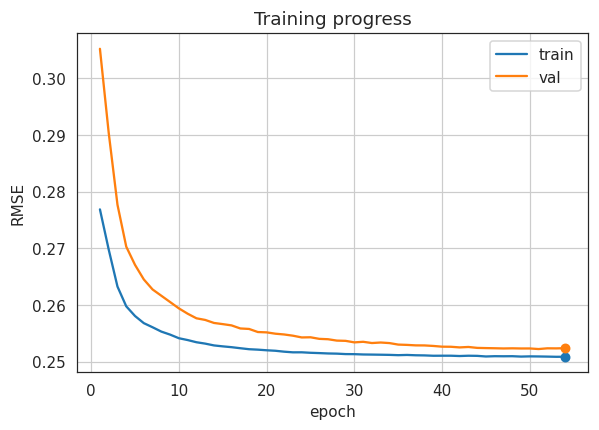

In [12]:
# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = params.device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")


In [13]:
# print("Any NaN in X?   ", torch.isnan(X).any().item())
# print("All finite in X? ", torch.isfinite(X).all().item())
# print("Any NaN in y_sig?", torch.isnan(y_sig).any().item())
# print("Any NaN in y_ret?", torch.isnan(y_ret).any().item())
